In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
data=pd.read_csv('data.csv')
data.drop('ID',axis=1,inplace=True)
data.reset_index(drop=True,inplace=True)

## TIME SERIES ***MODEL***

In [ ]:

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm


# Prepare data for ARIMA (only the 'pm25' column)
train_arima = train['pm25'].dropna()
test_arima = test['pm25']


# Use auto_arima to find optimal parameters
auto_arima_model = pm.auto_arima(train_arima, start_p=0, start_q=0,
                                 test='adf',       # Use adftest to find optimal 'd'
                                 max_p=5, max_q=5, m=1,
                                 start_P=0, seasonal=False,
                                 d=None,           # let model determine 'd'
                                 D=0, trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)


# Fit the best ARIMA model
arima_model = ARIMA(train_arima, order=auto_arima_model.order)
arima_result = arima_model.fit()


# Make predictions
predictions = arima_result.predict(start=len(train_arima), end=len(data)-1)


# Evaluate the model
rmse_arima = np.sqrt(mean_squared_error(test_arima, predictions))
print(f"RMSE of the ARIMA model: {rmse_arima}")


In [ ]:
data.tail()

,ID,date,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,...,lc_14,lc_21,lc_22,lc_23,lc_31,lc_32,lc_33,lc_41,lc_51,pm25
14479,ID_121648,2021-12-30,45.396195,9.282700,4.068290,0.018870,98.841926,31.136746,49.847023,1.102796,...,0,0,0,0,0,0,0,0,0,35.277410
14480,ID_121649,2021-12-31,45.523426,9.044600,2.058015,0.098848,99.243918,52.115708,23.179946,0.806201,...,0,0,0,0,0,0,0,0,0,36.501711
14481,ID_121650,2021-12-31,45.552326,9.227764,3.027432,0.005722,97.639251,54.555107,19.551793,0.751813,...,0,0,0,0,0,0,0,0,0,43.123672
14482,ID_121651,2021-12-31,45.443858,9.167945,3.726027,0.008928,97.957254,59.206698,49.125161,1.047037,...,0,0,0,0,0,0,0,0,0,31.561594
14483,ID_121652,2021-12-31,45.396195,9.282700,3.196689,0.037551,97.587888,52.566477,49.669836,1.031876,...,0,0,0,0,0,0,0,0,0,36.349442


## ***DATA Preprocessing***

In [ ]:

data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

test = data[data['date'] > '2021-10-01']
train= data[data['date'] <= '2021-10-01']

train=pd.get_dummies(train,columns=['type'])
test=pd.get_dummies(test,columns=['type'])



target = 'pm25'
features = [col for col in train.select_dtypes(include=np.number).columns if col != target]


standard = StandardScaler()
train[features] = standard.fit_transform(train[features])

test[features] = standard.transform(test[features])

X_train = train.drop(['pm25', 'date'], axis=1)
y_train = train['pm25']
X_test = test.drop(['pm25', 'date'], axis=1)
y_test = test['pm25']

test.reset_index(drop=True)

# Make predictions for train and test sets
train_predictions = arima_result.predict(start=0, end=len(train_arima)-1)
test_predictions = arima_result.predict(start=len(train_arima), end=len(data)-1)

# Add ARIMA predictions as new features
train['arima_pred'] = train_predictions
test['arima_pred'] = test_predictions.reset_index(drop=True)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
plt.figure(figsize=(10, 6))

# Plot data before October 1st
plt.plot(before_october['date'], before_october['pm25'], label='Before October 1st', color='blue')

# Plot data after October 1st
plt.plot(after_october['date'], after_october['pm25'], label='Testing (After October 1st)', color='red')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
import numpy as np

# Force predictions to use range-based index
train_predictions.index = np.arange(len(train_predictions))
test_predictions.index = np.arange(len(test_predictions))

test.index = np.arange(len(test_predictions))
train.index = np.arange(len(train_predictions))
# Now safe to assign
train['arima_pred'] = train_predictions
test['arima_pred'] = test_predictions

In [ ]:
train

,date,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,...,lc_41,lc_51,pm25,month,type_NS,type_SB,type_SI,type_UB,type_UT,arima_pred
0,2021-01-01,0.136739,0.645585,-1.667634,1.664105,1.936770,-1.843488,1.645606,-1.130482,-1.403587,...,0.0,-0.16086,43.984662,-1.560202,True,False,False,False,False,18.269061
1,2021-01-01,-3.681745,1.935621,-1.823811,1.240767,2.024499,-1.793788,0.787294,0.388537,-1.843067,...,0.0,-0.16086,44.498188,-1.560202,True,False,False,False,False,42.122182
2,2021-01-01,0.676081,0.356283,-1.701827,1.240767,1.889896,-1.833517,-0.593605,-0.479708,-0.729277,...,0.0,-0.16086,44.481305,-1.560202,True,False,False,False,False,42.856344
3,2021-01-01,0.744866,-1.640396,-1.716872,1.391959,2.024929,-1.802435,0.680681,0.081550,-0.138679,...,0.0,-0.16086,44.504281,-1.560202,False,True,False,False,False,43.000207
4,2021-01-01,-0.158574,0.264368,-1.568560,1.694343,1.525005,-1.845677,0.904360,-0.066525,-0.127590,...,0.0,-0.16086,45.083535,-1.560202,True,False,False,False,False,43.040299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,2021-09-30,0.789638,0.479785,0.269864,-0.331631,0.710490,-0.148346,-0.794748,-0.401793,-0.050417,...,0.0,-0.16086,10.221763,1.535976,False,False,False,False,True,11.189927
10859,2021-09-30,-0.485318,0.146417,0.467650,-0.331631,0.194909,-0.145480,0.922296,-0.177806,0.726120,...,0.0,-0.16086,12.512715,1.535976,False,False,False,False,True,10.666336
10860,2021-10-01,0.449941,-0.540978,-1.860615,-0.331631,0.829262,-1.433707,-0.128701,-0.483350,-0.908518,...,0.0,-0.16086,7.623192,1.922998,False,False,False,True,False,12.464021
10861,2021-10-01,0.789638,0.479785,-2.015004,-0.331631,1.117467,-1.503938,-0.351675,-0.970133,-1.381214,...,0.0,-0.16086,7.277001,1.922998,False,False,False,False,True,9.053965


In [ ]:
train

,date,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,...,lc_41,lc_51,pm25,month,type_NS,type_SB,type_SI,type_UB,type_UT,arima_pred
0,2021-01-01,0.136739,0.645585,-1.667634,1.664105,1.936770,-1.843488,1.645606,-1.130482,-1.403587,...,0.0,-0.16086,43.984662,-1.560202,True,False,False,False,False,18.269061
1,2021-01-01,-3.681745,1.935621,-1.823811,1.240767,2.024499,-1.793788,0.787294,0.388537,-1.843067,...,0.0,-0.16086,44.498188,-1.560202,True,False,False,False,False,42.122182
2,2021-01-01,0.676081,0.356283,-1.701827,1.240767,1.889896,-1.833517,-0.593605,-0.479708,-0.729277,...,0.0,-0.16086,44.481305,-1.560202,True,False,False,False,False,42.856344
3,2021-01-01,0.744866,-1.640396,-1.716872,1.391959,2.024929,-1.802435,0.680681,0.081550,-0.138679,...,0.0,-0.16086,44.504281,-1.560202,False,True,False,False,False,43.000207
4,2021-01-01,-0.158574,0.264368,-1.568560,1.694343,1.525005,-1.845677,0.904360,-0.066525,-0.127590,...,0.0,-0.16086,45.083535,-1.560202,True,False,False,False,False,43.040299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14105,2021-09-30,0.789638,0.479785,0.269864,-0.331631,0.710490,-0.148346,-0.794748,-0.401793,-0.050417,...,0.0,-0.16086,10.221763,1.535976,False,False,False,False,True,NaN
14106,2021-09-30,-0.485318,0.146417,0.467650,-0.331631,0.194909,-0.145480,0.922296,-0.177806,0.726120,...,0.0,-0.16086,12.512715,1.535976,False,False,False,False,True,NaN
14107,2021-10-01,0.449941,-0.540978,-1.860615,-0.331631,0.829262,-1.433707,-0.128701,-0.483350,-0.908518,...,0.0,-0.16086,7.623192,1.922998,False,False,False,True,False,NaN
14108,2021-10-01,0.789638,0.479785,-2.015004,-0.331631,1.117467,-1.503938,-0.351675,-0.970133,-1.381214,...,0.0,-0.16086,7.277001,1.922998,False,False,False,False,True,NaN


# ***pacf***

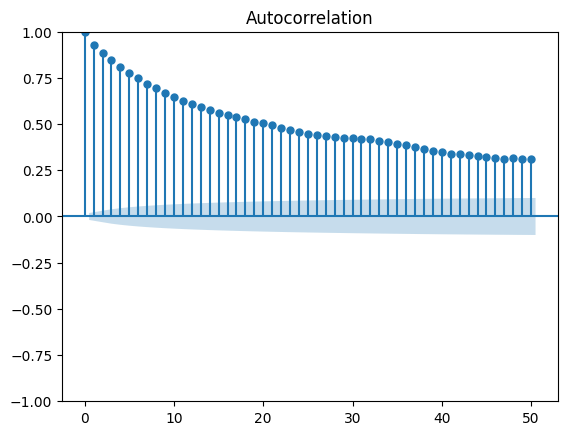

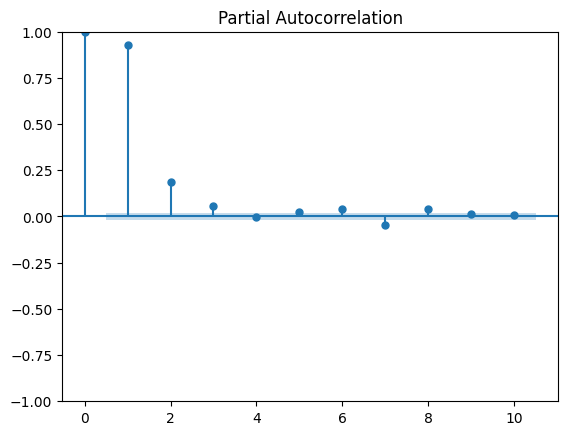

In [ ]:


import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Plot ACF
plot_acf(train['pm25'], lags=50)
plt.show()

# Plot PACF
plot_pacf(train['pm25'], lags=10)
plt.show()


# *correlation*

In [ ]:


correlation_matrix = train.corr()
correlation_matrix


,date,lat,lng,temperature,precipitation,humidity,global_radiation,hydrometric_level,N,NE,...,lc_51,pm25,type_NS,type_SB,type_SI,type_UB,type_UT,pm25_lag_1,pm25_lag_2,pm25_lag_3
date,1.000000,0.002170,-0.003687,0.493559,-0.038176,-0.124500,0.275780,-0.095455,0.040442,0.094803,...,0.000280,-0.483314,-0.000111,0.002901,-0.004023,0.004710,-0.004427,-0.480729,-0.478304,-0.476282
lat,0.002170,1.000000,-0.114636,-0.008555,0.032656,-0.022706,-0.012076,-0.423017,-0.105997,-0.128685,...,0.012264,-0.018080,-0.085784,-0.010961,0.061201,0.091779,0.008438,0.010752,0.007856,-0.014557
lng,-0.003687,-0.114636,1.000000,0.018900,0.000236,-0.068953,-0.002909,0.075725,-0.055496,-0.027628,...,0.095981,-0.001657,0.012577,-0.040590,-0.333111,-0.180948,0.303286,-0.003708,-0.007974,0.020483
temperature,0.493559,-0.008555,0.018900,1.000000,-0.034379,-0.473810,0.697864,-0.187089,0.066581,0.170954,...,-0.006399,-0.343017,0.003227,-0.010961,-0.009001,-0.006996,0.013010,-0.343914,-0.335685,-0.330817
precipitation,-0.038176,0.032656,0.000236,-0.034379,1.000000,0.400643,-0.343773,0.166996,0.142292,0.115909,...,-0.001631,-0.000969,0.001805,0.010716,0.001074,0.001849,-0.011434,0.003679,0.004621,0.004701
humidity,-0.124500,-0.022706,-0.068953,-0.473810,0.400643,1.000000,-0.780857,0.221406,-0.176617,-0.202283,...,-0.025099,0.304301,0.006190,0.039967,0.031163,0.011243,-0.056467,0.313329,0.297982,0.291743
global_radiation,0.275780,-0.012076,-0.002909,0.697864,-0.343773,-0.780857,1.000000,-0.258655,0.098446,0.143363,...,-0.002927,-0.353041,0.001348,0.002228,0.000605,0.003542,-0.006567,-0.348727,-0.342314,-0.337320
hydrometric_level,-0.095455,-0.423017,0.075725,-0.187089,0.166996,0.221406,-0.258655,1.000000,0.033419,-0.035462,...,0.156276,0.053115,-0.059741,0.050752,0.024522,-0.022700,0.051759,0.038223,0.052421,0.050793
N,0.040442,-0.105997,-0.055496,0.066581,0.142292,-0.176617,0.098446,0.033419,1.000000,0.584507,...,0.021308,-0.220874,0.039318,-0.056748,0.018539,0.035152,-0.050229,-0.210996,-0.190862,-0.186464
NE,0.094803,-0.128685,-0.027628,0.170954,0.115909,-0.202283,0.143363,-0.035462,0.584507,1.000000,...,-0.003110,-0.230789,0.041739,-0.107588,0.000676,0.015302,0.005186,-0.244306,-0.216971,-0.213139


## ***Target plot over time***

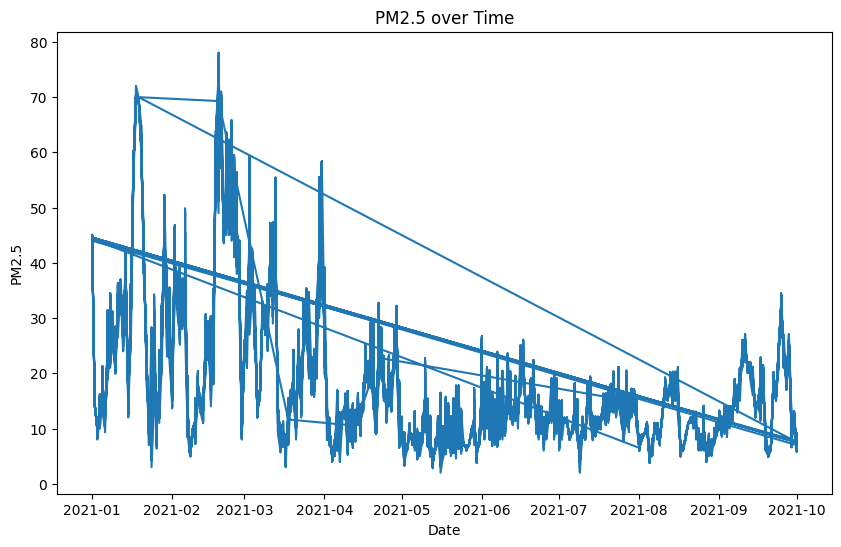

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['pm25'])
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 over Time')
plt.show()


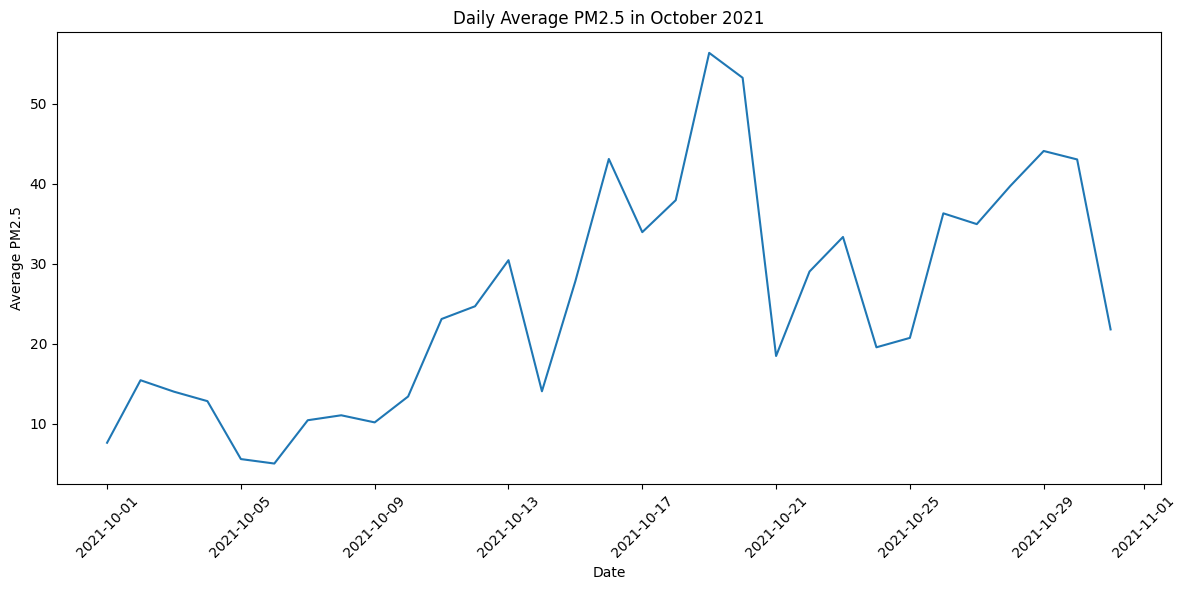

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


october_data = data[(data['date'] >= '2021-10-01') & (data['date'] <= '2021-10-31')]

# Group data by day and calculate the daily average PM2.5
daily_avg_pm25 = october_data.groupby(october_data['date'].dt.date)['pm25'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_pm25.index, daily_avg_pm25.values)
plt.xlabel('Date')
plt.ylabel('Average PM2.5')
plt.title('Daily Average PM2.5 in October 2021')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


# ***RF TUNED WITHOUT TIME***

In [ ]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np




# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200,500],
    'max_depth': [ 10, 20,5]
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=1,verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of the tuned Random Forest model: {rmse}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

# ***XGB TUNED WITHOUT TIME***

In [ ]:
# prompt: LETS TUNE XGB AND EVALUATE IT USING RMSE

import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7,15],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                              cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Get the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model using RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE of the tuned XGBoost model: {rmse_xgb}")


# ***tuned lgbm without time***

In [ ]:


import numpy as np
from lightgbm import LGBMRegressor

# Define the parameter grid for LGBM
param_grid_lgbm = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 15],
    'learning_rate': [0.01, 0.1]

}
# Initialize the LGBM regressor
lgbm_model = LGBMRegressor(random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm,
                              cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_lgbm.fit(X_train, y_train)

# Get the best LGBM model
best_lgbm_model = grid_search_lgbm.best_estimator_

# Make predictions
y_pred_lgbm = best_lgbm_model.predict(X_test)

# Evaluate the model using RMSE
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print(f"RMSE of the tuned LGBM model: {rmse_lgbm}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 10863, number of used features: 46
[LightGBM] [Info] Start training from score 18.259240
RMSE of the tuned LGBM model: 21.620816815611768


## ***direct mlp***

In [ ]:


import numpy as np
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor
mlp_model = MLPRegressor(random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the MLP model: {rmse_mlp}")


RMSE of the MLP model: 6.008458396687735


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## ***penalized linear regression***

In [ ]:
# prompt: penalized linear regression

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Initialize and train a penalized linear regression model (Ridge Regression)
ridge_model = Ridge(alpha=1.0)  # alpha controls the regularization strength
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model using RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE of the Ridge Regression model: {rmse_ridge}")

# Initialize and train Lasso Regression
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE of the Lasso Regression model: {rmse_lasso}")

# Initialize and train a standard linear regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the linear regression model
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f"RMSE of the Linear Regression model: {rmse_linear}")


RMSE of the Ridge Regression model: 5.479837594311801
RMSE of the Lasso Regression model: 5.494407750493942
RMSE of the Linear Regression model: 5.4848877286369015


# ***tuned mlp without time***

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor

# Define the parameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh']
}
# Initialize the MLPRegressor
mlp_model = MLPRegressor(random_state=42, max_iter=500) # Increased max_iter

# Perform GridSearchCV for hyperparameter tuning
grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid_mlp,
                              cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)
grid_search_mlp.fit(X_train, y_train)

# Get the best MLP model
best_mlp_model = grid_search_mlp.best_estimator_

# Make predictions
y_pred_mlp = best_mlp_model.predict(X_test)

# Evaluate the model using RMSE
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the tuned MLP model: {rmse_mlp}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END ..........activation=relu, hidden_layer_sizes=(50,); total time=   2.1s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END ..........activation=relu, hidden_layer_sizes=(50,); total time=   2.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........activation=relu, hidden_layer_sizes=(50,); total time=  37.8s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END ..........activation=relu, hidden_layer_sizes=(50,); total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........activation=relu, hidden_layer_sizes=(50,); total time=  36.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END .........activation=relu, hidden_layer_sizes=(100,); total time=  35.7s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END .........activation=relu, hidden_layer_sizes=(100,); total time=  22.3s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END .........activation=relu, hidden_layer_sizes=(100,); total time=   6.9s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END .........activation=relu, hidden_layer_sizes=(100,); total time=   1.1s


# *linear regression*

In [ ]:
# prompt: lets train a linear regression

import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model using RMSE
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f"RMSE of the Linear Regression model: {rmse_linear}")


RMSE of the Linear Regression model: 5.153408178924099


# ***RF***

In [ ]:

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
# Initialize the RandomForestRegressor without hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of the Random Forest model: {rmse}")


NameError: name 'RandomForestRegressor' is not defined

## ***DIRECT LGBM***

In [ ]:
# prompt: lets train lgbm without tuning

import numpy as np
# Initialize the LGBMRegressor without hyperparameter tuning
lgbm_model = LGBMRegressor(random_state=42)

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate the model using RMSE
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print(f"RMSE of the LGBM model: {rmse_lgbm}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4734
[LightGBM] [Info] Number of data points in the train set: 10863, number of used features: 49
[LightGBM] [Info] Start training from score 18.259240
RMSE of the LGBM model: 7.061866052407846


## ***MLP USING KERAS***

In [ ]:


import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error

# Define the MLP model
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer with 64 neurons
mlp_model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons
mlp_model.add(Dense(1))  # Output layer (regression)


# Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model using RMSE
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the MLP model (keras): {rmse_mlp}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 209.4442 - mse: 209.4442
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.4431 - mse: 24.4431
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.5503 - mse: 19.5503
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 17.2297 - mse: 17.2297
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 16.4071 - mse: 16.4071
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.3086 - mse: 17.3086
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.9500 - mse: 16.9500
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 16.5604 - mse: 16.5604
Epoch 9/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 15.1434 - mse: 15.1434
Epoch 10/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.9991 - mse: 16.9991
Epoch 11/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.7169 - mse: 14.7169
Epoch 12/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.6898 - mse: 15.6898

In [ ]:
X_train_perfect=X_train[]
X_test_perfect=X_test.copy()

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


# Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mse'])


# Train the model
mlp_model.fit(X_train, y_train, epochs=100, batch_size=64,
              validation_split=0.1, callbacks=[early_stop], verbose=1)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model using RMSE
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the MLP model (keras): {rmse_mlp}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 292.7811 - mse: 292.7811 - val_loss: 108.5983 - val_mse: 108.5983
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 111.6882 - mse: 111.6882 - val_loss: 97.5723 - val_mse: 97.5723
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 101.6108 - mse: 101.6108 - val_loss: 98.8669 - val_mse: 98.8669
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 101.0933 - mse: 101.0933 - val_loss: 87.5980 - val_mse: 87.5980
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93.2414 - mse: 93.2414 - val_loss: 80.0358 - val_mse: 80.0358
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 89.7158 - mse: 89.7158 - val_loss: 85.0004 - val_mse: 85.0004
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 88.5812 - mse: 88.5812 - val_loss: 75.8985 - val_mse: 75.8985
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 82.2113 - mse: 82.2113 - val_loss: 72.4882 - val_mse: 72.4882
Epoch 9/100
153/1

In [ ]:
# prompt: train lightgbm model

import numpy as np
# Initialize the LGBMRegressor without hyperparameter tuning
lgbm_model = LGBMRegressor(random_state=42)

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate the model using RMSE
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print(f"RMSE of the LGBM model: {rmse_lgbm}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 10863, number of used features: 46
[LightGBM] [Info] Start training from score 18.259240
RMSE of the LGBM model: 21.676914018809427


In [ ]:
!pip install pandas==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.2 requires joblib<1.4,>=1.2.0, but you have joblib 1.5.0 which is incompatible.
pycaret 3.3.2 requires numpy<1.27,>=1.21, but you have numpy 2.2.5 which is incompatible.
pycaret 3.3.2 requires scipy<=1.11.4,>=1.6.1, but you have scipy 1.15.3 which is incompatible.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
sktime 0.26.0 requires numpy<1.27,>=1.21, but you have numpy 2.2.5 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.
google

In [ ]:
import pandas as pd

In [ ]:
arima_test = pd.DataFrame(test['arima_pred']) # Change pd.df to pd.DataFrame
arima_test.to_csv('arima_test.csv')

arima_train =pd.DataFrame(train['arima_pred'])
arima_train.to_csv('arima_train.csv')

In [ ]:
# prompt: variable importance using lgbm

import pandas as pd
# Get feature importances from the trained LGBM model
feature_importances = best_lgbm_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importances
feature_importance_df


,Feature,Importance
2,temperature,1861
5,global_radiation,1616
48,month,1252
4,humidity,1215
10,SE,855
14,NW,840
13,W,838
9,E,823
7,N,779
8,NE,768


In [ ]:

columns_to_keep = ['arima_pred','temperature', 'global_radiation', 'month', 'humidity', 'SE', 'NW', 'W', 'E', 'N', 'NE', 'S', 'SW', 'hydrometric_level', 'precipitation', 'lng', 'lat', 'ndvi_2019', 'water_distance', 'dtm_milan', 'aspect', 'twi', 'spi', 'hillshade', 'profile_curvature', 'slope', 'plan_curvature', 'tri', 'dusaf15', 'geologia', 'type_UT', 'lc_12', 'type_SB', 'geo_1', 'type_NS', 'lc_14', 'lc_21', 'type_UB', 'pm25', 'date']


# Filter the DataFrame to keep only the desired columns
filtered_train = train[columns_to_keep]
filtered_test = test[columns_to_keep]


# For example:
print(filtered_train.head())


   arima_pred  temperature  global_radiation     month  humidity        SE  \
0   18.269061    -1.667634         -1.843488 -1.560202  1.936770 -1.549767   
1   42.122182    -1.823811         -1.793788 -1.560202  2.024499 -1.981693   
2   42.856344    -1.701827         -1.833517 -1.560202  1.889896 -0.782726   
3   43.000207    -1.716872         -1.802435 -1.560202  2.024929 -0.730597   
4   43.040299    -1.568560         -1.845677 -1.560202  1.525005 -1.585837   

         NW         W         E         N  ...  type_UT     lc_12  type_SB  \
0 -0.882518 -1.608887 -1.603532 -1.130482  ...    False  1.104175    False   
1  0.593525  1.498111 -1.856177  0.388537  ...    False -0.905653    False   
2 -0.157536 -0.660832 -0.849437 -0.479708  ...    False  1.104175    False   
3 -0.138415 -1.779297 -0.400781  0.081550  ...    False -0.905653     True   
4  0.102069 -0.373769  0.254313 -0.066525  ...    False  1.104175    False   

      geo_1  type_NS     lc_14     lc_21  type_UB       pm25  

In [ ]:
# prompt: lets train a linear regression using filtered data

import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming 'filtered_train' and 'filtered_test' are already created and contain the relevant features

# Define features (X) and target (y) for training
X_train_filtered = filtered_train.drop(['pm25', 'date'], axis=1)
y_train_filtered = filtered_train['pm25']

# Define features (X) and target (y) for testing
X_test_filtered = filtered_test.drop(['pm25', 'date'], axis=1)
y_test_filtered = filtered_test['pm25']

# Initialize and train the Linear Regression model
linear_model_filtered = LinearRegression()
linear_model_filtered.fit(X_train_filtered, y_train_filtered)

# Make predictions
y_pred_filtered = linear_model_filtered.predict(X_test_filtered)

# Evaluate the model using RMSE
rmse_filtered = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
print(f"RMSE of the Linear Regression model with filtered data: {rmse_filtered}")


RMSE of the Linear Regression model with filtered data: 18.876930896313784


In [ ]:
# prompt: now mlp of skit learn

import numpy as np
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor
mlp_model = MLPRegressor(random_state=42, hidden_layer_sizes=(100,50), max_iter=500)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the MLP model: {rmse_mlp}")


RMSE of the MLP model: 17.62869847801136


In [ ]:

import numpy as np
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor
mlp_model = MLPRegressor(random_state=42, hidden_layer_sizes=(100,50), max_iter=500)

# Train the model
mlp_model.fit(X_train_filtered, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test_filtered)

# Evaluate the model
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the MLP model: {rmse_mlp}")

RMSE of the MLP model: 18.677644026415393


In [ ]:
# prompt: now random forest

# Assuming X_train, y_train, X_test, and y_test are already defined as in your provided code

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of the Random Forest model: {rmse}")


RMSE of the Random Forest model: 20.942743000988564


In [ ]:
# prompt: mlp using keras

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Assuming X_train, y_train, X_test, and y_test are already defined

# Define the MLP model with dropout for regularization
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_filtered.shape[1],)),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    Dense(64, activation='relu'),
    Dropout(0.2),  # Another dropout layer
    Dense(32, activation='relu'),
    Dropout(0.2),  # Another dropout layer
    Dense(1)  # Output layer
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_history = mlp_model.fit(X_train_filtered, y_train, epochs=100, batch_size=64, validation_split=0.2)
# Make predictions
y_pred_mlp = mlp_model.predict(X_test_filtered)

# Evaluate the model
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"RMSE of the MLP model (keras): {rmse_mlp}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 215.0715 - mse: 215.0715 - val_loss: 26.1968 - val_mse: 26.1968
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 46.9883 - mse: 46.9883 - val_loss: 27.7990 - val_mse: 27.7990
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38.7770 - mse: 38.7770 - val_loss: 27.0771 - val_mse: 27.0771
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 35.1277 - mse: 35.1277 - val_loss: 27.1075 - val_mse: 27.1075
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.9693 - mse: 33.9693 - val_loss: 28.7737 - val_mse: 28.7737
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 32.8122 - mse: 32.8122 - val_loss: 26.2294 - val_mse: 26.2294
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.8791 - mse: 30.8791 - val_loss: 28.5542 - val_mse: 28.5542
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.8627 - mse: 30.8627 - val_loss: 28.2142 - val_mse: 28.2142
Epoch 9/100
136/136 ━━━━━━

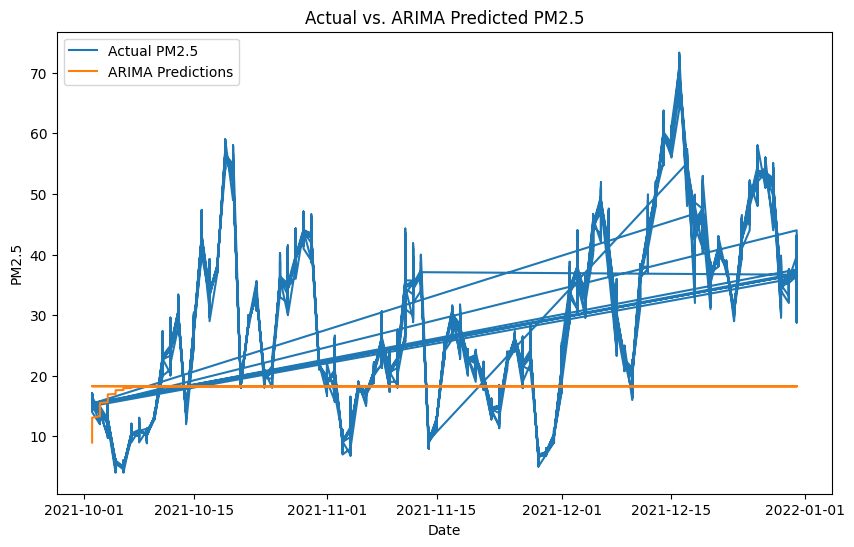

In [ ]:
# prompt: arima_pred-test pred graph

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test['pm25'], label='Actual PM2.5')
plt.plot(test['date'], test['arima_pred'], label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Actual vs. ARIMA Predicted PM2.5')
plt.legend()
plt.show()


In [ ]:
# prompt: let's try knn

import numpy as np
from sklearn.neighbors import KNeighborsRegressor

# Initialize the KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=6)  # You can adjust the number of neighbors

# Train the model
knn_model.fit(X_train_filtered, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_filtered)

# Evaluate the model
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print(f"RMSE of the KNN model: {rmse_knn}")


RMSE of the KNN model: 18.594950922369858
